In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline, utils
from modules import spec_tools


# Readin of Data

In [4]:
data_pd, data_np = spec_tools.data_read_csv("shee2.csv",";",",")

x = data_np[:,0]
y = data_np[:,1]






Further give the user the possibility to plot a spectral window

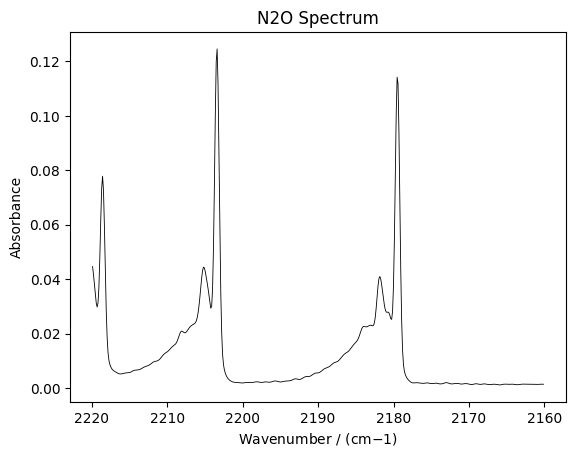

In [5]:
def plot_spectral_window(x,y,spectral_window,title):
    """ 
    Plots a given spectral window for the IR data

    Attr:
        x: x-data
        y: y-data
        spectral_window: a tuple with the spectral window
        title: a string with the title
    
    Returns:
        A Plot of the Spectral Window with the selected data
    """
    # Select the data using the spectral window
    mask = np.logical_and(x >= spectral_window[1], x <= spectral_window[0])
    x_window = x[mask]
    y_window = y[mask]

    plt.plot(x_window, y_window, label="Spectral Window", color ="black",linewidth = 0.6)
    plt.gca().invert_xaxis()
    plt.xlabel("Wavenumber / (cm${-1}$)")
    plt.ylabel("Absorbance")
    plt.title(title)
    plt.show()
    return x_window, y_window

x_window, y_window = plot_spectral_window(x,y,(2220,2160),"N2O Spectrum")   


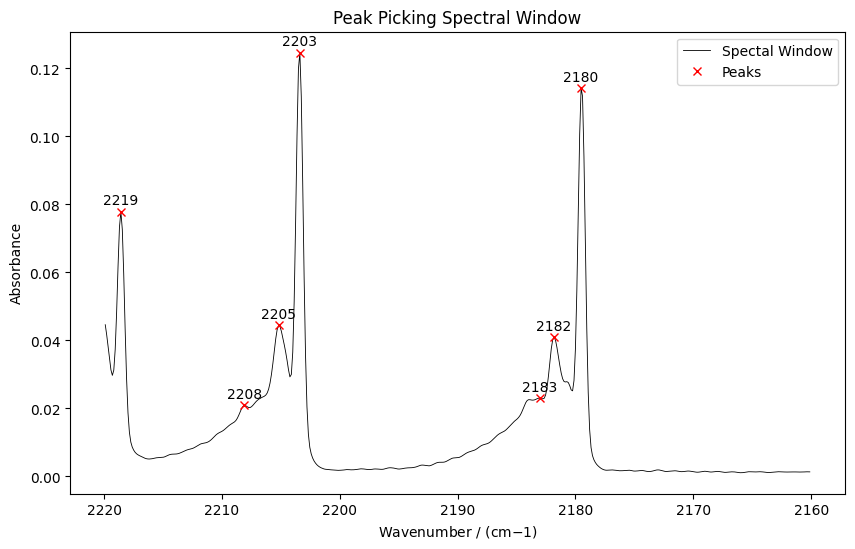

{'peak_heights': array([0.07783, 0.02089, 0.04441, 0.12462, 0.02306, 0.04098, 0.11421])}


In [6]:
from scipy.signal import find_peaks

def peak_picking_spectral_window(x_window,y_window,height=None,distance=None,prominence=None):
    """
    Applies Peak Picking to a given spectral window

    Attr:
        x_window: x-data of spectral window
        y_window: y-data of spectral window
        height: Required height of Peaks, optional
        distance: Required horizontal distance between peaks
        prominence: Required prominence of peaks
    """

    peaks, properties = find_peaks(y_window, height=height, distance=distance, prominence=prominence)

    plt.figure(figsize=(10,6))
    plt.plot(x_window,y_window, label="Spectal Window", color = "black",linewidth = 0.6)
    plt.plot(x_window[peaks],y_window[peaks], "x", label="Peaks", color ="Red")
    plt.gca().invert_xaxis()
    plt.title("Peak Picking Spectral Window")
    plt.xlabel("Wavenumber / (cm${-1}$)")
    plt.ylabel("Absorbance")
    plt.legend()

    for peak in peaks:
        plt.annotate(f"{x_window[peak]:.0f}", (x_window[peak],y_window[peak]),textcoords="offset points", xytext=(0,5), ha="center")
    plt.show()

    return peaks,properties

peaks,properties = peak_picking_spectral_window(x_window,y_window, 0.02,10)

print(properties)

# Baseline fitting methods

## Asls / Aspls Methods

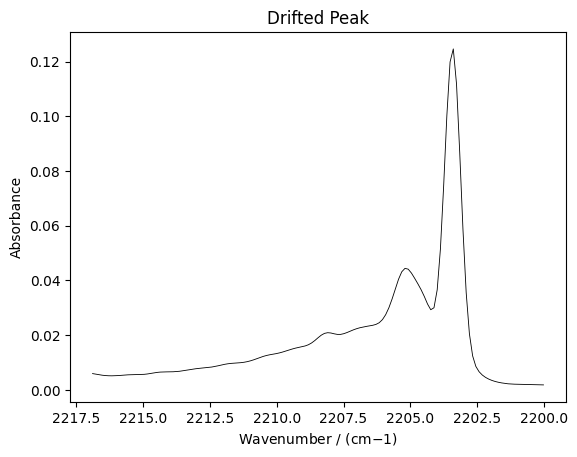

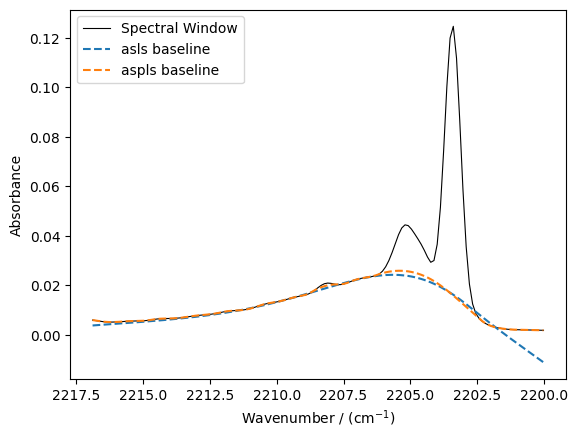

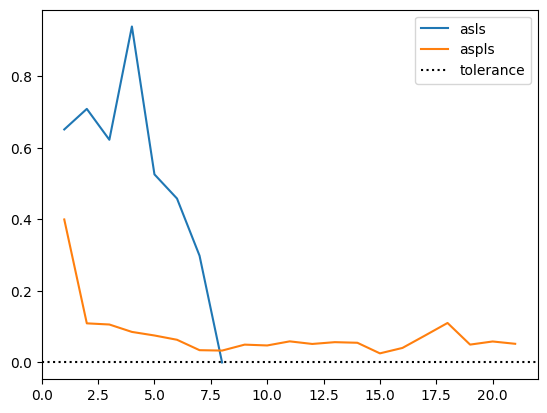

In [7]:
# first of select a good spectral window to try this



x_window_base, y_window_base = plot_spectral_window(x,y,(2217,2200),"Drifted Peak")

def fit_baseline_asls_aspls(x_window,y_window, lam, tol, max_iter):
    """ 
    Fits the Baseline using  the Asymmetrically reweighted penalized least squares smoothing

    Also fits Baseline using the Asymmetrically Least Squares smoothing and compares the convergence
    
    Attr:
        x_window = selected x data
        y_window = selected y data
        lam =  
        tol = 
        max_iter
    """
    baseline_fitter= Baseline(x_window)

    fit1,params_1 = baseline_fitter.asls(y_window, lam=lam, tol=tol, max_iter=max_iter)
    fit2,params_2 = baseline_fitter.aspls(y_window, lam=lam, tol=tol, max_iter=max_iter)


    plt.plot(x_window,y_window, label ="Spectral Window", color ="black", linewidth = 0.8)
    plt.plot(x_window,fit1, label="asls baseline", ls = "--")
    plt.plot(x_window,fit2, label="aspls baseline", ls = "--")
    plt.legend()
    plt.xlabel("Wavenumber / (cm$^{-1}$)")
    plt.ylabel("Absorbance")
    plt.legend()
    plt.gca().invert_xaxis()
    plt.show()

    # Next of show the Fits
    plt.figure()
    plt.plot(np.arange(1, len(params_1["tol_history"]) + 1), params_1["tol_history"], label="asls")
    plt.plot(np.arange(1, len(params_2["tol_history"]) + 1), params_2["tol_history"], label="aspls")
    plt.axhline(tol, ls=":", color="k", label="tolerance")
    plt.legend()
    plt.show()

    baseline_corrected_spectrum_asls = y_window - fit2
    baseline_corrected_spectrum_aspls = y_window - fit2
    return baseline_corrected_spectrum_asls, baseline_corrected_spectrum_aspls

y_window_asls, y_window_aspls = fit_baseline_asls_aspls(x_window_base,y_window_base, 1e3, 1e-3, 20)



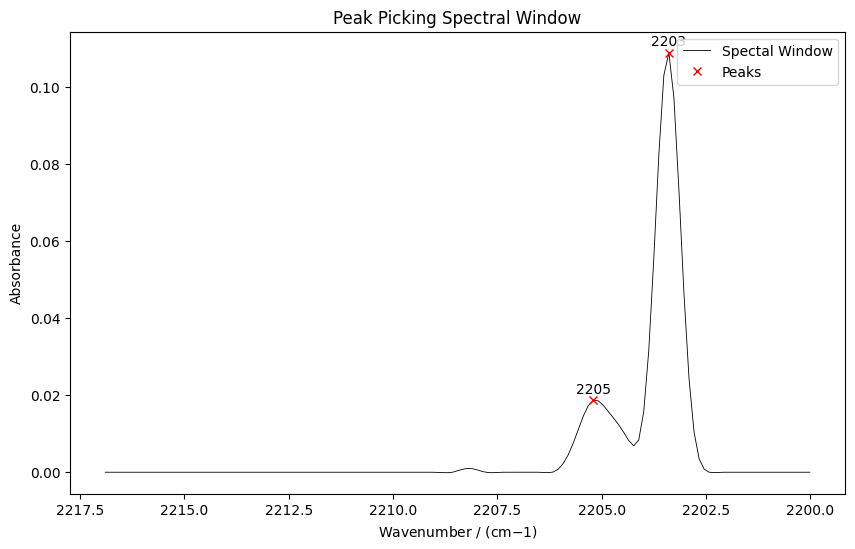

(array([ 97, 112]), {'peak_heights': array([0.0186404 , 0.10877024])})

In [8]:
peak_picking_spectral_window(x_window_base,y_window_asls, height=0.01)

## Try baseline correction polynomial 

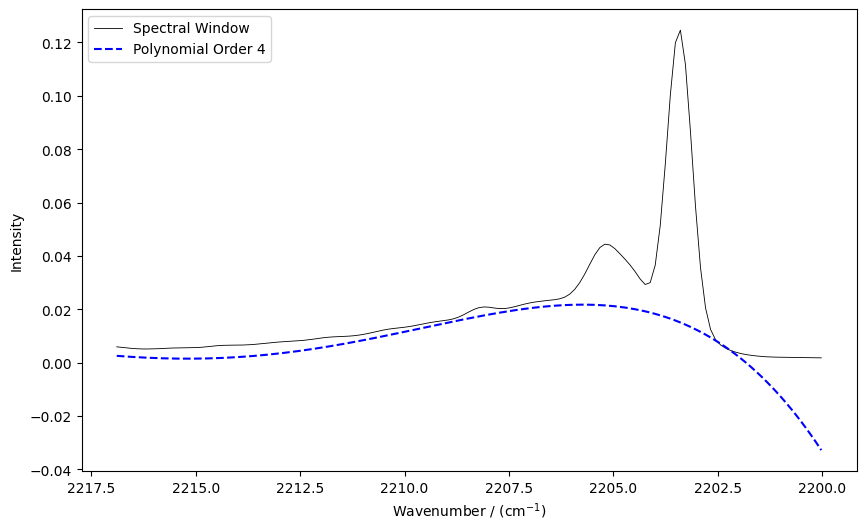

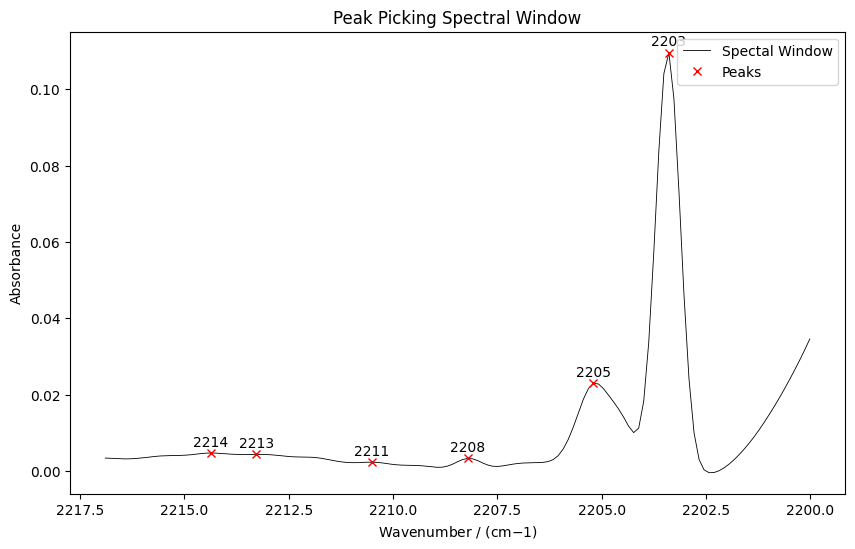

(array([ 21,  30,  53,  72,  97, 112]), {})

In [16]:
def fit_baseline_poly(x_window,y_window,p):
    """
    Fits the Baseline using Modpoly method

    Attr:
        x_window = selected x data
        y_window = selected y data
        p = degree of polyomial
    """

    baseline_fitter = Baseline(x_window)

    fit, params = baseline_fitter.modpoly(y_window,poly_order=p)
    
    plt.figure(figsize=(10,6))
    plt.plot(x_window,y_window, label="Spectral Window", color = "black", linewidth = 0.6)
    plt.gca().invert_xaxis()
    plt.plot(x_window, fit, label=f"Polynomial Order {p}", color="blue", ls="--")
    plt.legend()
    plt.xlabel("Wavenumber / (cm$^{-1}$)")
    plt.ylabel("Intensity")

    baseline_correted_spectrum_modpoly = y_window - fit
    return baseline_correted_spectrum_modpoly


y_window_modpoly = fit_baseline_poly(x_window_base,y_window_base,4)

peak_picking_spectral_window(x_window_base,y_window_modpoly)

## Morphological Baseline Fitting

Optimal HAlf window is approximately equal to the FWHM of the widest peak


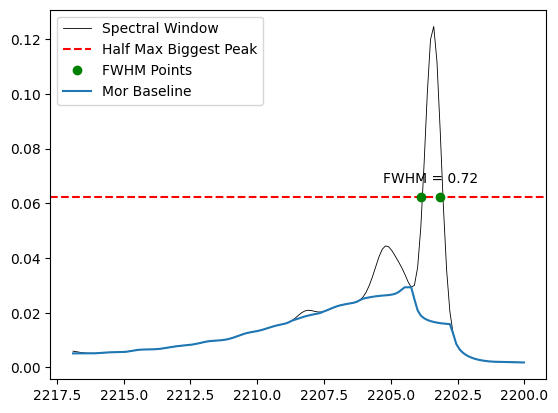

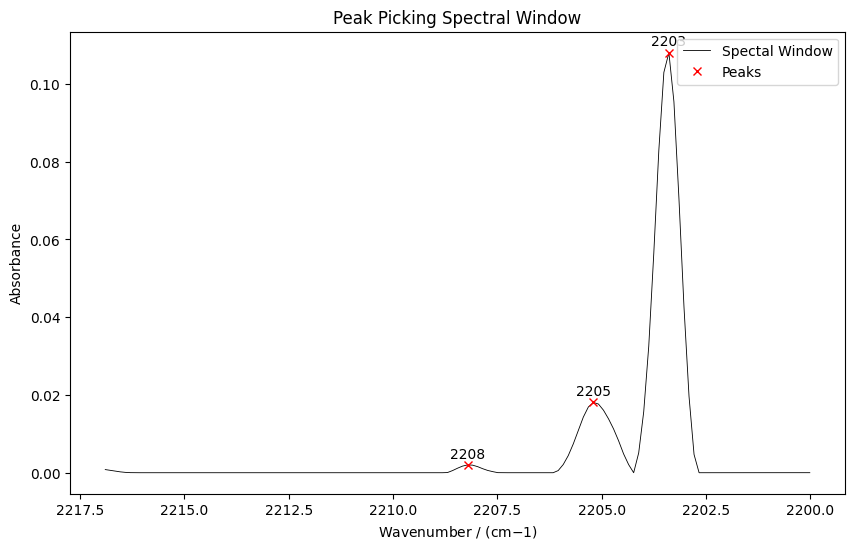

(array([ 72,  97, 112]), {})

In [17]:
from scipy.interpolate import interp1d

def fit_baseline_morph(x_window,y_window, offset):
    """ 
    Performs a baseline fit by using a morphology based method,
    this algorithm also approximates the half_window by using the FWHM of the largest peak

    Attr:
        x_window = selected x data
        y_window = selected y data
        offset = offset to addjust half_window size
    """
    baseline_fitter = Baseline(x_window)

    peak_idx = np.argmax(y_window)
    peak_value = y_window[peak_idx]

    half_max = peak_value/2

    interpolator = interp1d(x_window,y_window-half_max, kind="linear", fill_value="extrapolate")
    roots = np.where(np.diff(np.sign(interpolator(x_window))))[0]

    if len(roots) >= 2:
        fwhm = np.abs(x_window[roots[-1]] - x_window[roots[0]])
        x_left = x_window[roots[-1]]
        x_right = x_window[roots[0]]
    
    
    fit, params = baseline_fitter.mor(y_window,half_window=round(fwhm)+offset)




    plt.plot(x_window,y_window, color = "black", linewidth = 0.6, label="Spectral Window")
    plt.axhline(half_max, color = "red", ls = "--", label="Half Max Biggest Peak")
    plt.gca().invert_xaxis()
    plt.plot([x_left,x_right],[half_max,half_max], "go", label="FWHM Points")
    plt.plot(x_window, fit, label="Mor Baseline")
    plt.annotate(f"FWHM = {fwhm:.2f}", xy=((x_left + x_right)/2, half_max), xytext=(0,10), textcoords="offset points", ha="center")
    plt.legend()

    baseline_corrected_spectrum_morph = y_window - fit
    return baseline_corrected_spectrum_morph

y_window_morph = fit_baseline_morph(x_window_base,y_window_base,10)

peak_picking_spectral_window(x_window_base,y_window_morph)
    

# Comparison Methods to calculate the derivative spectrum

## Method 1 Finite Differences


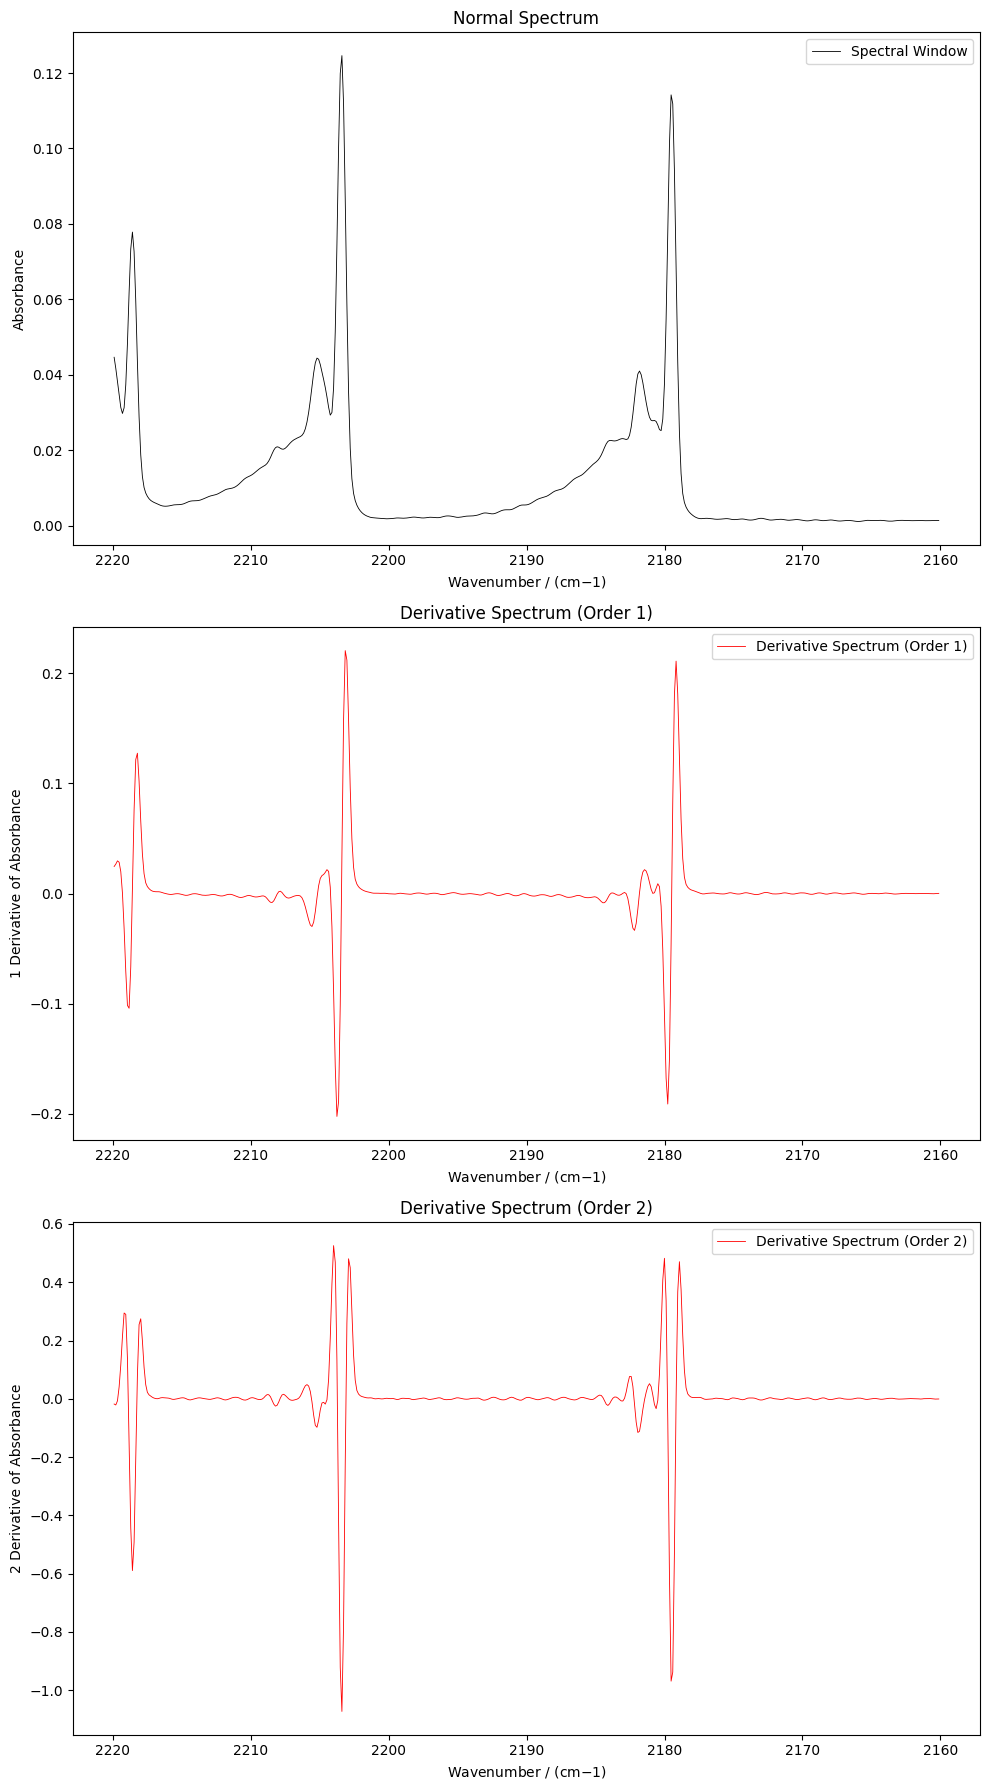

In [18]:


def finite_differences(x,y, order=1):
    """ 
    Gradient or first derivative is computed using central differences as the interior points or first, second order accurate one sides
    differences at the boundary
    """
    dydx = y
    for _ in range(order):
        dydx = np.gradient(dydx,x)
    return dydx

def plot_derivative_spectrum(x_window, y_window, method="finite", max_order=2):
    """ 
    Calculates and plots the derivative spectrum using different methods for derivative computation.

    Methods:
        "finite": computation by finite differences (central differences)
    """
    fig, axes = plt.subplots(max_order + 1, 1, figsize=(10, 6 * (max_order + 1)))

    # Plot the normal spectrum
    axes[0].plot(x_window, y_window, label="Spectral Window", color="black", linewidth=0.6)
    axes[0].invert_xaxis()
    axes[0].set_title("Normal Spectrum")
    axes[0].set_xlabel("Wavenumber / (cm${-1}$)")
    axes[0].set_ylabel("Absorbance")
    axes[0].legend()

    # Plot the derivative spectra iteratively
    for order in range(1, max_order + 1):
        if method == "finite":
            y_prime_window = finite_differences(x_window, y_window, order=order)
        
        axes[order].plot(x_window, y_prime_window, label=f"Derivative Spectrum (Order {order})", color="red", linewidth=0.6)
        axes[order].invert_xaxis()
        axes[order].set_title(f"Derivative Spectrum (Order {order})")
        axes[order].set_xlabel("Wavenumber / (cm${-1}$)")
        axes[order].set_ylabel(f"{order} Derivative of Absorbance")
        axes[order].legend()

    plt.tight_layout()
    plt.show()

plot_derivative_spectrum(x_window,y_window,max_order=2)

    

## Zero Crossing Determination 

For a given spectral window, and a derivative spectrum:

1. Calculate the Second Derivative
2. Identify the Maximums and Minimums in the Second Derivative

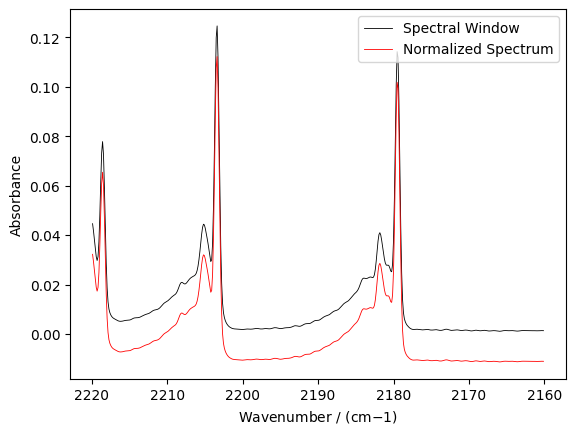

In [19]:
# Normalize a Spectrum to zero

def normalize_spectrum(x_window,y_window):
    """ 
    Normalizes a spectrum to zero with a mean
    """
    y_window_normalized = y_window - np.mean(y_window)
    return y_window_normalized

plt.plot(x_window, y_window, label="Spectral Window", color="black", linewidth=0.6)
plt.plot(x_window, normalize_spectrum(x_window, y_window), label="Normalized Spectrum", color="red", linewidth=0.6)
plt.gca().invert_xaxis()
plt.xlabel("Wavenumber / (cm${-1}$)")
plt.ylabel("Absorbance")
plt.legend()
plt.show()

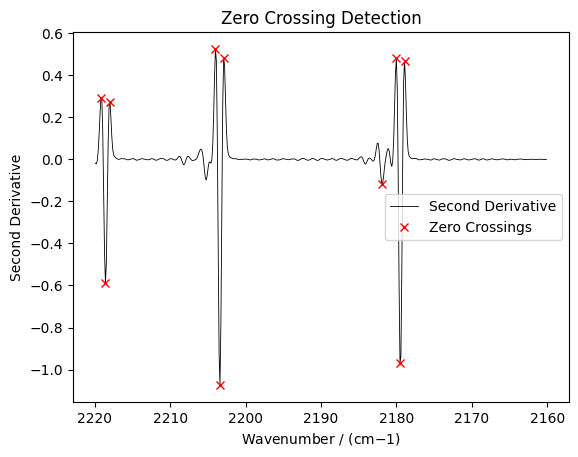

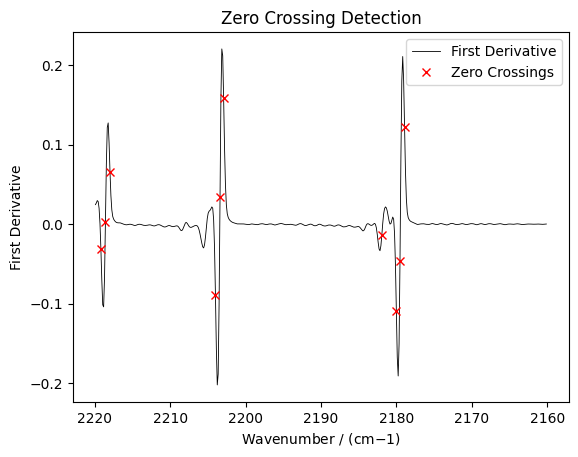

In [20]:

def zero_crossing_det(x_window,y_prime_window,method="derivative",threshold=0.1):
    """ 
    Determine possible zero crossings:

    Attr
    """
    y_double_prime = finite_differences(x_window,y_prime_window,order=1)
    
    # Zero Crossings are Maxima in second derivative
    peaks,_ = find_peaks(y_double_prime, height=threshold)
    neg_peaks , _ = find_peaks(-y_double_prime, height=threshold)
    peaks = np.concatenate([peaks,neg_peaks])
    
    
    plt.plot(x_window,y_double_prime, label="Second Derivative", color="black", linewidth=0.6)
    plt.plot(x_window[peaks],y_double_prime[peaks], "x", label="Zero Crossings", color="red")
    plt.gca().invert_xaxis()
    plt.title("Zero Crossing Detection")
    plt.xlabel("Wavenumber / (cm${-1}$)")
    plt.ylabel("Second Derivative")
    plt.legend()
    plt.show()
    
    return peaks

y_prime_window = finite_differences(x_window,y_window,order=1)
zero_crossings = zero_crossing_det(x_window,y_prime_window,threshold=0.1)

# plot peaks in derivative spectrum
plt.plot(x_window, y_prime_window, label="First Derivative", color="black", linewidth=0.6)
plt.plot(x_window[zero_crossings], y_prime_window[zero_crossings], "x", label="Zero Crossings", color="red")
plt.gca().invert_xaxis()
plt.title("Zero Crossing Detection")
plt.xlabel("Wavenumber / (cm${-1}$)")
plt.ylabel("First Derivative")
plt.legend()
plt.show()

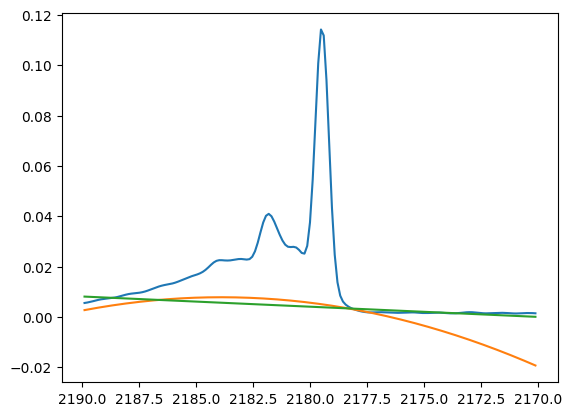

In [21]:
x_peaks = x[np.where(x > 2170)]
x_peaks = x_peaks[np.where(x_peaks < 2190)]
# find the indices of original data
indices = np.where(np.isin(x, x_peaks))
y_peak = y[indices]


baseline_fitter = Baseline(x_peaks)

bk_1, params_1 = baseline_fitter.modpoly(y_peak, poly_order=2)
bk_2, params_2 = baseline_fitter.asls(y_peak, lam=1e10, p=0.02)



plt.plot(x_peaks, y_peak)
plt.plot(x_peaks, bk_1)
plt.plot(x_peaks, bk_2)
plt.gca().invert_xaxis()
plt.show()

In [22]:
y_prime_peak = derivative_spectrum(y_peak)
zero_crossings, zero_crossings_indices = find_zero_crossing_lin_int(x_peaks, y_prime_peak)

plt.plot(x_peaks, y_prime_peak)
plt.scatter(zero_crossings, np.zeros(len(zero_crossings)), color="red")
plt.gca().invert_xaxis()

step_size = x_peaks[1] - x_peaks[0]
print(step_size)


NameError: name 'derivative_spectrum' is not defined

In [ ]:

right_bound, left_bound = optimize_and_plot(x_peaks, y_prime_peak, zero_crossings_indices, 6, zero_crossings_indices[8], zero_crossings_indices[4], bound_type='left', step_size=1)
print(right_bound, left_bound)
print(x_peaks.shape)



In [ ]:
area = np.trapz(y_peak[right_bound:left_bound], x_peaks[right_bound:left_bound])
print(area)
plt.plot(x_peaks, y_peak)
plt.fill_between(x_peaks[right_bound:left_bound], y_peak[right_bound:left_bound], color='blue', alpha=0.3)

In [ ]:
right_bound2, left_bound2 = optimize_and_plot(x_peaks, y_prime_peak, zero_crossings_indices, 4, zero_crossings_indices[5] - 5, zero_crossings_indices[3], bound_type='left', step_size=1)

In [ ]:
area_2 = np.trapz(y_peak[right_bound2:left_bound2], x_peaks[right_bound2:left_bound2])
print(area_2)
plt.plot(x_peaks, y_peak)
plt.fill_between(x_peaks[right_bound2:left_bound2], y_peak[right_bound2:left_bound2], color='blue', alpha=0.3)
plt.fill_between(x_peaks[right_bound:left_bound], y_peak[right_bound:left_bound], color='green', alpha=0.3)

print("Area_ratio: " + str(area/area_2))